# Retrieval Augmented Generation (RAG) for Cybersecurity, Pentesting, and Hacking

This notebook demonstrates a modular RAG pipeline that integrates with an LLM and supports previous conversations. The goal is to improve LLM responses for cybersecurity topics by augmenting them with relevant retrieved information.

## Objectives
- Build a modular RAG pipeline for cybersecurity, pentesting, and hacking topics.
- Integrate previous conversation context to improve LLM responses.
- Use clean, separated modules for each pipeline stage.
- Provide clear instructions and explanations for each step.

## Pipeline Overview
1. **Preprocessing**: Clean and prepare data/documents for retrieval.
2. **Retrieval**: Find relevant documents or passages based on a query.
3. **Previous Conversation Handling**: Integrate chat history into the retrieval and generation process.
4. **Inference**: Use an LLM to generate responses augmented with retrieved information.

## 1. Preprocessing: Load and Prepare Data
Load and preprocess the provided datasets for retrieval.

In [7]:
from datasets import load_dataset
import pandas as pd

# Load the Hugging Face dataset
pentesting_dataset = load_dataset("preemware/pentesting-eval")

# Extract questions and answers from the dataset
questions = pentesting_dataset['train']['question']
answers = pentesting_dataset['train']['answer']
explanations = pentesting_dataset['train']['explanation']

# Create a DataFrame with questions and their corresponding answers
combined_df = pd.DataFrame({
    'question': questions,
    'answer': answers,
    'explanation': explanations
})

# Map integer answer index to the actual answer string from choices
choices = pentesting_dataset['train']['choices']
combined_df['answer_text'] = [row[ans] if ans < len(row) else '' for row, ans in zip(choices, combined_df['answer'])]

# Preprocess the content - convert to string, lowercase and strip whitespace
combined_df['processed_question'] = combined_df['question'].astype(str).apply(lambda x: x.lower().strip())
combined_df['processed_answer'] = combined_df['answer_text'].astype(str).apply(lambda x: x.lower().strip())

# Display the first few rows of the dataset
combined_df.head()

,question,answer,explanation,answer_text,processed_question,processed_answer
0,What is the most effective technique for ident...,3,Using sandboxing technologies to observe behav...,Using sandboxing technologies to observe behavior,what is the most effective technique for ident...,using sandboxing technologies to observe behavior
1,"When conducting a penetration test, what techn...",1,"Using a slow, methodical scan technique is the...","Using a slow, methodical scan technique","when conducting a penetration test, what techn...","using a slow, methodical scan technique"
2,"In the context of exploit development, what te...",2,Executing a buffer overflow attack to gain una...,Executing a buffer overflow attack to gain una...,"in the context of exploit development, what te...",executing a buffer overflow attack to gain una...
3,In the context of developing an exploit for a ...,1,A stack-based buffer overflow is a common expl...,Stack-based buffer overflow,in the context of developing an exploit for a ...,stack-based buffer overflow
4,In the context of modern exploit development f...,1,"ROP chaining, or Return-Oriented Programming, ...",ROP chaining,in the context of modern exploit development f...,rop chaining


## 2. Retrieval: Embed and Index Documents
We use a sentence transformer to embed documents and FAISS for efficient similarity search.

In [8]:
!pip install faiss-cpu

from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Load a pre-trained sentence transformer model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Embed the processed questions
corpus = combined_df['processed_question'].tolist()
corpus_embeddings = embedder.encode(corpus, convert_to_numpy=True)

# Build a FAISS index
dimension = corpus_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(corpus_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

## 3. Previous Conversation Handling
We maintain a chat history and use it to augment the retrieval and generation process.

In [9]:
# Example previous conversation (can be extended in real use)
chat_history = [
    "What is phishing?",
    "How can I prevent phishing attacks?",
    "What are the examples of phising attacks"
]

# Combine chat history into a single context string
conversation_context = " ".join(chat_history)

## 4. Inference: Generate LLM Response with Retrieved Context
We retrieve relevant documents based on the latest user query and pass them, along with the conversation context, to the LLM for response generation.

In [10]:
from transformers import pipeline

# Use a lightweight LLM for demonstration (distilbert-base-uncased-finetuned-sst-2-english for sentiment, replace with a generative model for real use)
generator = pipeline('text2text-generation', model='google/flan-t5-small')

def retrieve(query, top_k=2):
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    D, I = index.search(query_embedding, top_k)
    return [corpus[i] for i in I[0]]

# Example user query
user_query = "Explain SQL injection."
retrieved_docs = retrieve(user_query)

# Prepare prompt for LLM
prompt = f"Context: {' '.join(retrieved_docs)}\nConversation: {conversation_context}\nUser: {user_query}\nAnswer:"

# Generate response
response = generator(prompt, max_new_tokens=100, num_return_sequences=1)[0]['generated_text']
print(response)

Device set to use cuda:0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Using a phishing attack, you can use SQL injection to detect a vulnerability.


## 5. Pipeline Explanation and Design Choices
- **Retrieval**: We use sentence-transformers for semantic search and FAISS for fast vector similarity.
- **LLM**: For demonstration, we use a lightweight open-source model. For production, consider larger models (e.g., Llama, GPT-3, or domain-specific LLMs).
- **Previous Conversation**: The chat history is concatenated and included in the prompt to help the LLM maintain context.
- **Cybersecurity Data**: The pipeline is modular and can ingest any cybersecurity-related documents or datasets.

You can extend this notebook by:
- Using a larger or domain-specific LLM.
- Improving preprocessing (e.g., chunking, advanced cleaning).
- Enhancing retrieval (e.g., hybrid search, reranking).
- Integrating with real chat interfaces.

## 6. References and Further Reading
- [Sentence Transformers Documentation](https://www.sbert.net/)
- [FAISS Documentation](https://faiss.ai/)
- [HuggingFace Transformers](https://huggingface.co/docs/transformers/index)
- [RAG Paper (Facebook AI)](https://arxiv.org/abs/2005.11401)

## 7. Testing the RAG Pipeline
This section demonstrates how to test the RAG pipeline by running queries and generating responses using the LLM.

In [11]:
# Example: Test the RAG pipeline with a query

# Define a test query
user_query = "What are the common cybersecurity threats in 2024?"

# Retrieve relevant documents
retrieved_docs = retrieve(user_query)

# Prepare the prompt for the LLM
prompt = f"Context: {' '.join(retrieved_docs)}\nConversation: {conversation_context}\nUser: {user_query}\nAnswer:"

# Generate a response
response = generator(prompt, max_new_tokens=50, num_return_sequences=1)[0]['generated_text']

# Display the response
print("Query:", user_query)
print("\nGenerated Response:", response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Query: What are the common cybersecurity threats in 2024?

Generated Response: apts


## 8. Evaluation of the RAG Pipeline
This section evaluates the RAG pipeline using the `preemware/pentesting-eval` dataset. We sample 10-20% of the data, generate responses, and compare them with the ground truth using quantitative and qualitative metrics.

In [12]:
import random
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import pandas as pd

# Download required NLTK data
nltk.download('punkt')

# Sample 10% of the dataset for evaluation
eval_sample = combined_df.sample(frac=0.1, random_state=42)

# Generate responses and compare with ground truth
queries = []
ground_truths = []
generated_responses = []
match_scores = []  # Binary scores for exact matches

for idx, row in eval_sample.iterrows():
    query = row['processed_question']
    answer = row['processed_answer']
    explanation = row['explanation']
    queries.append(query)
    ground_truths.append(answer)

    # Retrieve relevant documents and include explanation in context
    retrieved_docs = retrieve(query)
    context_docs = retrieved_docs + [explanation]

    # Prepare a more focused prompt for exact answer matching
    prompt = f"""Context: {' '.join(context_docs)}
Question: {query}
Instructions: Based on the context, provide only the specific answer number or exact technical response.
Answer with just the solution, no explanations.
Answer:"""

    # Generate a concise response
    response = generator(prompt, max_new_tokens=50, num_return_sequences=1)[0]['generated_text']
    
    # Extract and clean the response
    response = response.split('Answer:')[-1].strip()
    # Remove any additional explanations after the answer
    response = response.split('.')[0].strip()
    generated_responses.append(response)
    
    # Calculate exact match (binary score)
    match_scores.append(1 if response.lower() == answer.lower() else 0)

# Create a DataFrame with evaluation results
eval_results = pd.DataFrame({
    'Question': queries,
    'Ground Truth': ground_truths,
    'Generated Response': generated_responses,
    'Exact Match': match_scores
})

# Calculate response length statistics
eval_results['Ground Truth Length'] = eval_results['Ground Truth'].str.len()
eval_results['Generated Length'] = eval_results['Generated Response'].str.len()
eval_results['Length Difference'] = eval_results['Generated Length'] - eval_results['Ground Truth Length']

# Print statistical summary
print("Statistical Summary:")
print("==================")
print(f"Exact Match Rate: {eval_results['Exact Match'].mean():.2%}")
print(f"Average Ground Truth Length: {eval_results['Ground Truth Length'].mean():.1f} characters")
print(f"Average Generated Length: {eval_results['Generated Length'].mean():.1f} characters")

# Create sample comparison tables
print("\nExamples of Exact Matches:")
print("=======================")
matches = eval_results[eval_results['Exact Match'] == 1].head()
print(matches[['Question', 'Ground Truth', 'Generated Response']].to_string(index=False))

print("\nExamples of Non-Matches:")
print("=====================")
non_matches = eval_results[eval_results['Exact Match'] == 0].head()
print(non_matches[['Question', 'Ground Truth', 'Generated Response']].to_string(index=False))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Statistical Summary:
Exact Match Rate: 45.83%
Average Ground Truth Length: 36.5 characters
Average Generated Length: 36.0 characters

Examples of Exact Matches:
                                                                                                                                                                                                  Question                                            Ground Truth                                      Generated Response
                         in the context of malware analysis, which technique is most effective at evading signature-based antivirus detection while maintaining the original functionality of the malware? using a polymorphic engine to modify the malware's code Using a polymorphic engine to modify the malware's code
                                              in the context of network-level exploits, which vulnerability specifically relies on the misuse of the smb protocol by windows systems for its exploitation?       

In [13]:
print(pentesting_dataset['train'].features)

{'answer': Value(dtype='int64', id=None), 'choices': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'explanation': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None)}


In [14]:
print(combined_df[['question', 'answer', 'processed_answer']].head(10))

                                            question  answer  \
0  What is the most effective technique for ident...       3   
1  When conducting a penetration test, what techn...       1   
2  In the context of exploit development, what te...       2   
3  In the context of developing an exploit for a ...       1   
4  In the context of modern exploit development f...       1   
5  What is the underlying cause of the Heartbleed...       0   
6  In the context of malware analysis, which tech...       0   
7  In the context of exploit development for buff...       0   
8  In the context of developing an exploit for a ...       0   
9  In the context of buffer overflow vulnerabilit...       1   

                                    processed_answer  
0  using sandboxing technologies to observe behavior  
1            using a slow, methodical scan technique  
2  executing a buffer overflow attack to gain una...  
3                        stack-based buffer overflow  
4                   

## 9. Evaluation Report
This section provides a detailed analysis of the RAG pipeline's performance, including sample comparisons and qualitative results.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


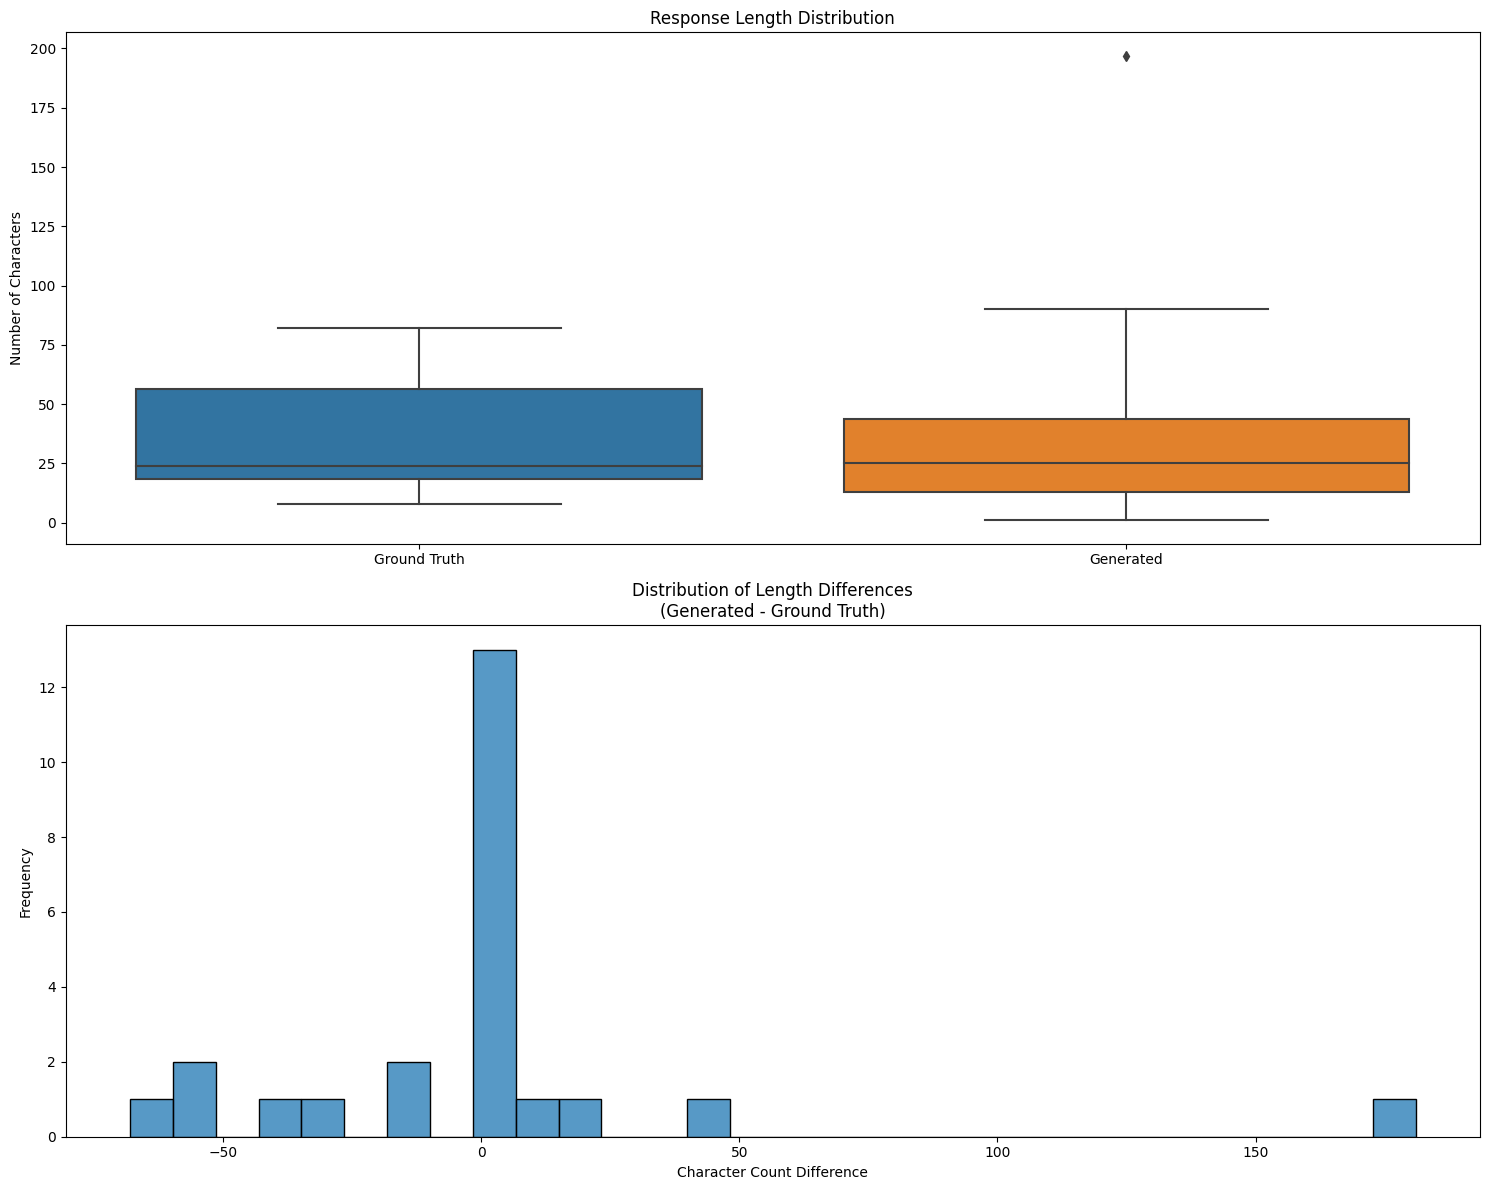

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualizations
plt.figure(figsize=(15, 12))

# 1. Response Length Comparison
plt.subplot(2, 1, 1)
data = pd.DataFrame({
    'Ground Truth': eval_results['Ground Truth Length'],
    'Generated': eval_results['Generated Length']
})
sns.boxplot(data=data)
plt.title('Response Length Distribution')
plt.ylabel('Number of Characters')

# 2. Length Difference Distribution
plt.subplot(2, 1, 2)
sns.histplot(data=eval_results['Length Difference'], bins=30)
plt.title('Distribution of Length Differences\n(Generated - Ground Truth)')
plt.xlabel('Character Count Difference')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()